## Load Dataset and Filter Store 262

We load the `train.csv` file from the `data/` directory using a clean, cross-platform path with `pathlib`. Then, we filter the dataset to only include records for **Store 262**, which we selected earlier because it has the highest total sales. This store provides rich data for modeling and reflects strong holiday effects observed in the regression analysis.


In [1]:
import pandas as pd
from pathlib import Path

file_path = Path("..") / "data" / "train.csv"
df = pd.read_csv(file_path)

df = df[df['Store'] == 262].copy()


C:\Users\Zaki\AppData\Local\Temp\ipykernel_47336\3892108874.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


> ℹ️ Note: We use `copy()` after filtering to avoid `SettingWithCopyWarning` and ensure data is handled safely downstream.


## Preprocessing

We extract and transform key features from the dataset to prepare it for modeling:

- **DayOfWeek**: Extracted from the date to capture weekly seasonality.
- **Promo** and **SchoolHoliday**: Converted to integers for model compatibility.
- **StateHoliday**: Converted to string and one-hot encoded into binary features:
  - `StateHoliday_a`, `StateHoliday_b`, and `StateHoliday_c` indicate different types of public holidays.
- **Sales > 0**: We remove rows where sales are zero, which usually indicate store closure days and would distort the model or error metrics like MAPE.

All transformations are wrapped in a reusable `preprocess()` function for cleaner code and consistency.


In [2]:
df['Date'] = pd.to_datetime(df['Date'])

def preprocess(df):
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Promo'] = df['Promo'].astype(int)
    df['SchoolHoliday'] = df['SchoolHoliday'].astype(int)
    df['StateHoliday'] = df['StateHoliday'].astype(str)
    df['StateHoliday_a'] = (df['StateHoliday'] == 'a').astype(int)
    df['StateHoliday_b'] = (df['StateHoliday'] == 'b').astype(int)
    df['StateHoliday_c'] = (df['StateHoliday'] == 'c').astype(int)
    return df

df = preprocess(df)

df = df[df['Sales'] > 0]  


##  Train-Test Split (80/20)

To evaluate the forecasting models reliably, we perform an 80/20 **chronological split** on the dataset. This ensures that all validation data comes **after** the training data in time, simulating a real-world scenario where we predict the future based on the past.

- The first 80% of the data is used for training.
- The remaining 20% is used for validation (testing).
- Data is sorted by date before splitting to preserve the temporal order.


In [3]:
df = df.sort_values("Date").reset_index(drop=True)
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index].copy()
valid_df = df.iloc[split_index:].copy()


## Forecast Evaluation Function

This function, evaluate_forecast, is used to evaluate the performance of time series forecasting models using three common error metrics:

- MAE (Mean Absolute Error):
Measures the average magnitude of the errors in a set of forecasts, without considering their direction.

- RMSE (Root Mean Squared Error):
Similar to MAE, but penalizes larger errors more heavily by squaring the differences before averaging.

- MAPE (Mean Absolute Percentage Error):
Expresses forecast accuracy as a percentage, making it easier to interpret across different scales.

**Function Parameters:**
  - `y_true`: Ground truth (actual) values

  - `y_pred`: Predicted values from the model

  - `model_name`: A string used to label the output for identification

**Function Behavior:**
- Prints formatted MAE, RMSE, and MAPE values

- Returns a dictionary containing all three metrics and the model name

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"📊 {model_name} Evaluation")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%\n")
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mape}

## Forecasting with Prophet: With and Without Holidays

This section compares the performance of two Prophet models:

1. Without Holidays – a baseline model using only seasonality and trend.

2. With Holidays – includes custom holiday effects based on the StateHoliday variables (a, b, c).

**Prophet Setup**
- Prophet requires columns named:

  - `ds`: the datetime column

  - `y`: the target variable (sales)

- Both the training and validation sets are prepared using appropriate column renaming.

**Custom Holiday Definition**
- Holidays are created using the `StateHoliday_a`, `StateHoliday_b`, and `StateHoliday_c` columns from the training set.

- Each holiday is assigned:

  - lower_window = 0

  - upper_window = 1
    This allows the holiday effect to span two days (the holiday and the next day).

**Evaluation**
- Forecasts are generated using predict() on the validation set.

- Predictions are merged with actual sales for evaluation.

- The `evaluate_forecast()` function is used to calculate:

  - MAE – Mean Absolute Error

  - RMSE – Root Mean Squared Error

  - MAPE – Mean Absolute Percentage Error

This comparison highlights the importance of incorporating holiday effects when forecasting sales in retail environments.

In [5]:
from prophet import Prophet

# Prophet needs 'ds' and 'y'
prophet_train = train_df.rename(columns={'Date': 'ds', 'Sales': 'y'})[['ds', 'y']]
prophet_valid = valid_df[['Date', 'Sales']].rename(columns={'Date': 'ds'})

# --- Prophet WITHOUT holidays ---
model_no_holidays = Prophet(daily_seasonality=True)
model_no_holidays.fit(prophet_train)
forecast_no_holidays = model_no_holidays.predict(prophet_valid[['ds']])
result1 = forecast_no_holidays[['ds', 'yhat']].merge(prophet_valid, on='ds')
eval1 = evaluate_forecast(result1['Sales'], result1['yhat'], "Prophet (No Holidays)")

# --- Prophet WITH holidays ---
holiday_df = pd.concat([
    pd.DataFrame({
        'holiday': f'state_holiday_{h}',
        'ds': train_df[train_df[f'StateHoliday_{h}'] == 1]['Date'].drop_duplicates(),
        'lower_window': 0,
        'upper_window': 1
    }) for h in ['a', 'b', 'c']
])
model_holidays = Prophet(daily_seasonality=True, holidays=holiday_df)
model_holidays.fit(prophet_train)
forecast_holidays = model_holidays.predict(prophet_valid[['ds']])
result2 = forecast_holidays[['ds', 'yhat']].merge(prophet_valid, on='ds')
eval2 = evaluate_forecast(result2['Sales'], result2['yhat'], "Prophet (With Holidays)")


c:\Users\Zaki\anaconda3\envs\rossmann_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
17:49:15 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing


📊 Prophet (No Holidays) Evaluation
MAE : 2328.58
RMSE: 3529.33
MAPE: 10.69%

📊 Prophet (With Holidays) Evaluation
MAE : 2229.70
RMSE: 3582.18
MAPE: 9.99%



## Forecasting with SARIMA: With and Without Holidays
This section implements and evaluates two SARIMA models for daily sales forecasting:

1. SARIMA without holidays – uses only autoregressive and seasonal components.

2. SARIMA with holidays – adds dummy variables (`StateHoliday_a`, `StateHoliday_b`, `StateHoliday_c`) as exogenous variables to capture holiday effects.

**Data Preparation**
- The dataset is reindexed by `Date` with daily frequency using `asfreq('D')` to meet SARIMA's requirement for a consistent time index.

- Missing values are forward-filled to avoid errors during training.

**Model Configurations**
- Order: `(1, 1, 1)` — ARIMA part (AR, differencing, MA)

- Seasonal Order: `(1, 1, 1, 7)` — assumes weekly seasonality

- Exogenous Variables:

  - `StateHoliday_a`: National holidays

  - `StateHoliday_b`: Religious holidays

  - `StateHoliday_c`: Other national celebrations

**Forecasting & Evaluation**
- Predictions are generated using `.forecast()` for the length of the validation set.

- When using exogenous variables, the validation set must include the corresponding dummy columns.

- Evaluation is performed using the evaluate_forecast() function with metrics:

  - MAE

  - RMSE

  - MAPE

This approach allows us to assess whether adding holiday-specific features improves forecast accuracy for time series with external events.

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reindex for SARIMA
sarima_train = train_df.set_index('Date').asfreq('D').fillna(method='ffill')
sarima_valid = valid_df.set_index('Date').asfreq('D').fillna(method='ffill')

# --- SARIMA WITHOUT holiday dummies ---
model_sarima_nohol = SARIMAX(sarima_train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,7))
res_sarima_nohol = model_sarima_nohol.fit(disp=False)
pred_nohol = res_sarima_nohol.forecast(steps=len(sarima_valid))
eval3 = evaluate_forecast(sarima_valid['Sales'], pred_nohol, "SARIMA (No Holidays)")

# --- SARIMA WITH holiday dummies ---
exog_train = sarima_train[['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]
exog_valid = sarima_valid[['StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]

model_sarima_hol = SARIMAX(sarima_train['Sales'], order=(1,1,1), seasonal_order=(1,1,1,7), exog=exog_train)
res_sarima_hol = model_sarima_hol.fit(disp=False)
pred_hol = res_sarima_hol.forecast(steps=len(sarima_valid), exog=exog_valid)
eval4 = evaluate_forecast(sarima_valid['Sales'], pred_hol, "SARIMA (With Holidays)")


C:\Users\Zaki\AppData\Local\Temp\ipykernel_47336\2328604097.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sarima_train = train_df.set_index('Date').asfreq('D').fillna(method='ffill')
C:\Users\Zaki\AppData\Local\Temp\ipykernel_47336\2328604097.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sarima_valid = valid_df.set_index('Date').asfreq('D').fillna(method='ffill')
c:\Users\Zaki\anaconda3\envs\rossmann_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


📊 SARIMA (No Holidays) Evaluation
MAE : 4049.58
RMSE: 5347.77
MAPE: 17.80%

📊 SARIMA (With Holidays) Evaluation
MAE : 1886.13
RMSE: 2635.34
MAPE: 9.10%



## Model Comparison Table

In [11]:
eval_table = pd.DataFrame([eval1, eval2, eval3, eval4])
print("\n📊 Model Comparison Table:")
print(eval_table.to_markdown(index=False))



📊 Model Comparison Table:
| Model                   |     MAE |    RMSE |     MAPE |
|:------------------------|--------:|--------:|---------:|
| Prophet (No Holidays)   | 2328.58 | 3529.33 | 10.6866  |
| Prophet (With Holidays) | 2229.7  | 3582.18 |  9.99324 |
| SARIMA (No Holidays)    | 4049.58 | 5347.77 | 17.7951  |
| SARIMA (With Holidays)  | 1886.13 | 2635.34 |  9.1016  |


## Actual vs Forecasted Sales (Validation Set) — Without Holidays
This plot presents a comparison between actual sales and forecasted sales generated by two models: SARIMA and Prophet, both excluding holiday effects.

**Description:**
- Actual Sales: Shown as a solid line, representing the true observed sales over the validation period.

- Prophet (Without Holidays): Shown with a dashed line (--), this forecast is from the Prophet model without considering holiday features.

- SARIMA (Without Holidays): Displayed as a dotted line (:), this forecast comes from the SARIMA model, also without including any holiday components.

**Insights:**
This visualization allows us to evaluate how well both models perform without the influence of holiday variables. It’s especially useful to:

- Observe how omitting holidays affects prediction accuracy.

- Benchmark model behavior in "normal" conditions.

- Compare this plot with the holiday-inclusive version to assess the impact of holidays on forecasting performance.

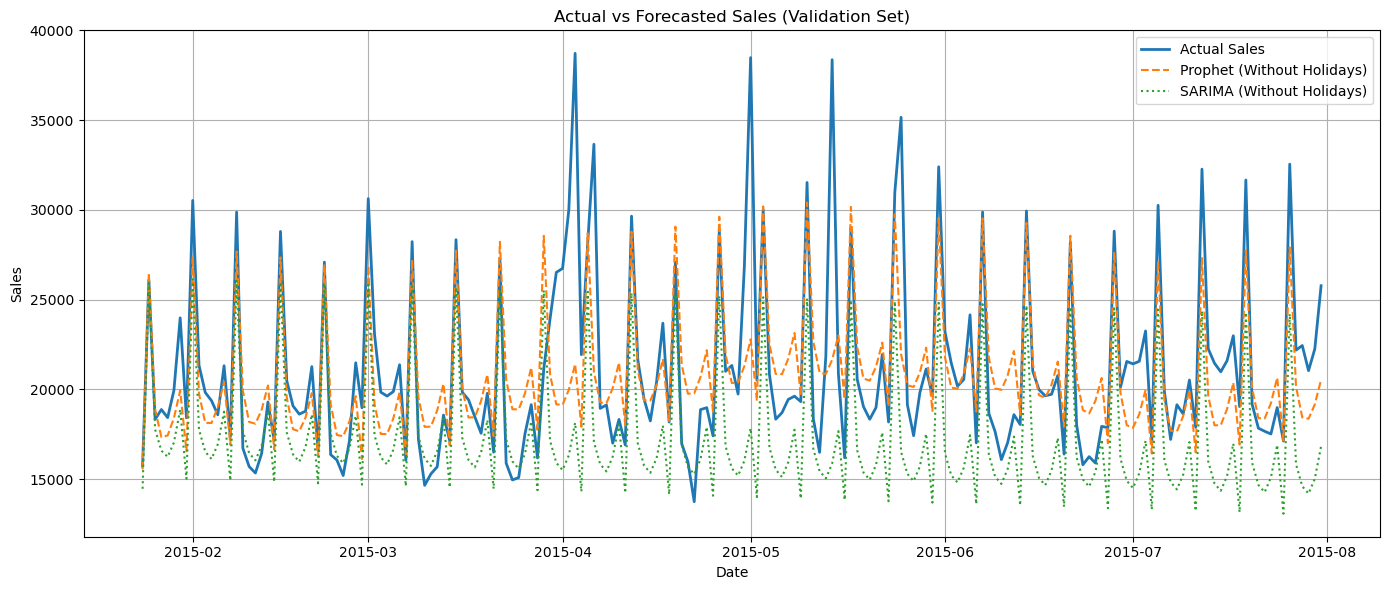

In [12]:
import matplotlib.pyplot as plt

# Make sure dates align
sarima_plot_df = sarima_valid.copy()
sarima_plot_df['SARIMA_Pred'] = pred_nohol.values
sarima_plot_df = sarima_plot_df.reset_index()[['Date', 'Sales', 'SARIMA_Pred']]

prophet_plot_df = result1[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Prophet_Pred'})

# Merge all into one
combined_df = sarima_plot_df.merge(prophet_plot_df, on='Date')

plt.figure(figsize=(14, 6))

plt.plot(combined_df['Date'], combined_df['Sales'], label='Actual Sales', linewidth=2)
plt.plot(combined_df['Date'], combined_df['Prophet_Pred'], label='Prophet (Without Holidays)', linestyle='--')
plt.plot(combined_df['Date'], combined_df['SARIMA_Pred'], label='SARIMA (Without Holidays)', linestyle=':')

plt.title('Actual vs Forecasted Sales (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Actual vs Forecasted Sales (Validation Set) — With Holidays
This plot compares the actual sales data against two forecasted models: SARIMA and Prophet, both incorporating holiday effects.

**Description:**
- Actual Sales: Represented by a solid line, this shows the real observed sales data during the validation period.

- Prophet (With Holidays): Displayed with a dashed line (--), this forecast was generated using the Prophet model with holiday features integrated.

- SARIMA (With Holidays): Shown as a dotted line (:), this forecast was produced using the SARIMA model, also considering holiday effects.

**Insights:**
This visualization helps assess which model better captures the sales trends, especially during holiday periods. It allows quick visual comparison of prediction accuracy and alignment with real sales data.

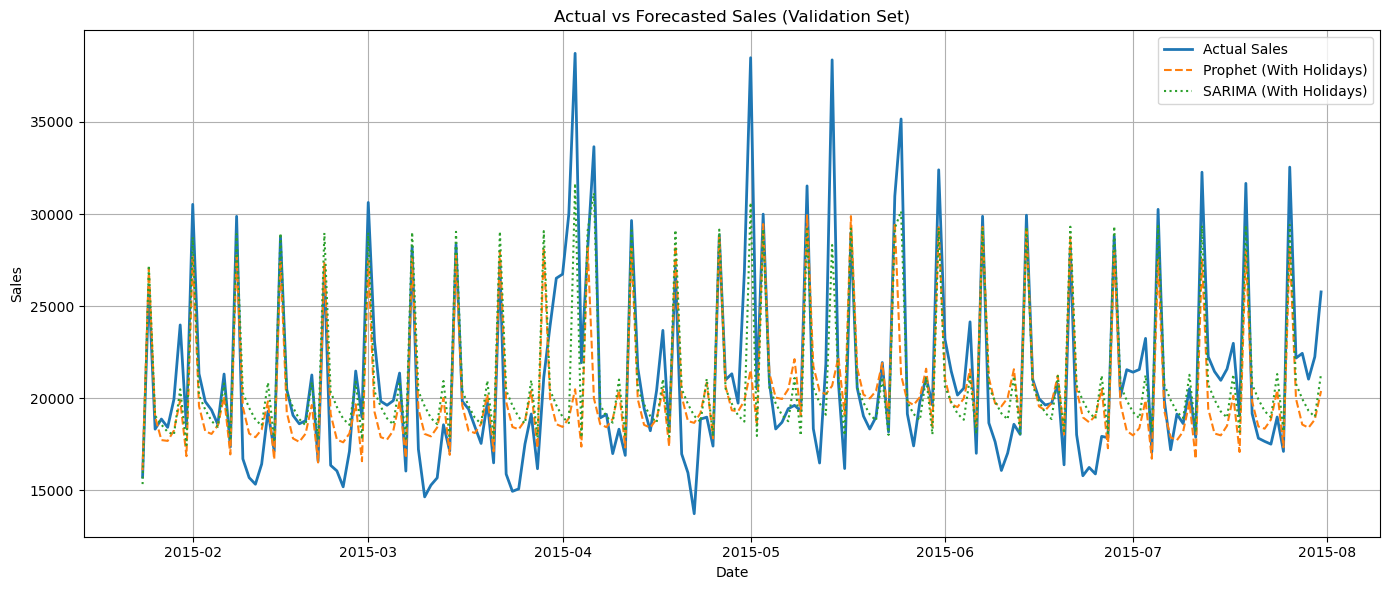

In [9]:
import matplotlib.pyplot as plt

# Make sure dates align
sarima_plot_df = sarima_valid.copy()
sarima_plot_df['SARIMA_Pred'] = pred_hol.values
sarima_plot_df = sarima_plot_df.reset_index()[['Date', 'Sales', 'SARIMA_Pred']]

prophet_plot_df = result2[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Prophet_Pred'})

# Merge all into one
combined_df = sarima_plot_df.merge(prophet_plot_df, on='Date')

plt.figure(figsize=(14, 6))

plt.plot(combined_df['Date'], combined_df['Sales'], label='Actual Sales', linewidth=2)
plt.plot(combined_df['Date'], combined_df['Prophet_Pred'], label='Prophet (With Holidays)', linestyle='--')
plt.plot(combined_df['Date'], combined_df['SARIMA_Pred'], label='SARIMA (With Holidays)', linestyle=':')

plt.title('Actual vs Forecasted Sales (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
